# Draw Catan Board

This notebook contains the code for visualising a board using the `drawsvg` library.

In [1]:
from ipynb.fs.full.hex_grid import *
import numpy as np
import drawsvg as draw

In [2]:
def flatten_list(point_list: list[Point]) -> list[float]:
    return [i for point in point_list for i in point]

In [3]:
layout_pointy = Orientation(sqrt(3.0), sqrt(3.0) / 2.0, 0.0, 3.0 / 2.0, sqrt(3.0) / 3.0, -1.0 / 3.0, 0.0, 2.0 / 3.0, 0.5)
layout_flat = Orientation(3.0 / 2.0, 0.0, sqrt(3.0) / 2.0, sqrt(3.0), 2.0 / 3.0, 0.0, -1.0 / 3.0, sqrt(3.0) / 3.0, 0.0)
layout_grid = Layout(layout_pointy, 35, Point(0,0))
layout_background = Layout(layout_flat, 200, Point(0,0))
width = 600
height = width
hex_colours = {
    0: '#DCBB96',
    1: '#DFB853',
    2: '#20703D',
    3: '#A7C957',
    4: '#C37C3A',
    5: '#969696',
    6: '#B9E3F3'
}
token_fill_colour = "#FFEDD0"
token_text_colour = ("#BD0000", "#100C08")
harbour_colours = { # Darker shades of hex_colours
    0: '#2A1B0D',
    1: '#D9A82E',
    2: '#1B5F34',
    3: '#93B93C',
    4: '#A86B32',
    5: '#969696'
}

team_colours = {
    0: '#CB4335',
    1: '#3498DB',
    2: '#E67E22 ',
    3: '#ECF0F1'
}

font_family = "Open Sans"
stroke_colour = "#100C08"
stroke_width = 2

In [4]:
def roll_freq(value: int) -> int:
    # Returns the relative frequency of rolling the value with two fair six sided dice
    assert value >= 2 and value <= 12
    freq = 6 - abs(7 - value)
    return freq

In [5]:
def init_canvas(width: int, heigh: int) -> draw.drawing.Drawing:
    return draw.Drawing(width, height, origin='center')

def draw_background(d: draw.drawing.Drawing, layout: Layout) -> None:
    vertices = hex_to_vertex_pixels(layout, Hex(0,0,0))
    d.append(draw.Lines(*flatten_list(vertices),
                        close=True,
                        fill=hex_colours[6],
                        stroke=stroke_colour, 
                        stroke_width=stroke_width), z=0)

def draw_grid(d: draw.drawing.Drawing, layout: Layout, grid: list) -> None:
    for hex_ in grid:
        vertices = hex_to_vertex_pixels(layout, hex_)
        d.append(draw.Lines(*flatten_list(vertices),
                            close=True,
                            fill='#FFFFFF',
                            stroke=stroke_colour, 
                            stroke_width=stroke_width,
                            hexcoord = hex_), z=1) # draw doesn't store underscores in fields

def draw_hex_coords(d: draw.drawing.Drawing, layout: Layout, grid: list) -> None:
    for hex_ in grid:
        center = hex_to_center_pixel(layout, hex_)
        d.append(draw.Text(str(hex_), 
                           font_size=10, 
                           x=center.x, y=center.y, center=True, 
                           valign = 'middle', 
                           font_family = "Open  Sans", 
                           fill = 'black'), z=2)

def draw_hexes(d: draw.drawing.Drawing, grid: list, board: list) -> None:
    for element in d.all_elements():
        try:
            hex_ = element.args['hexcoord'] 
            hex_type = board['types'][grid.index(hex_)]
            element.args['fill'] = hex_colours[hex_type]
        except KeyError:
            pass

def draw_tokens(
    d: draw.drawing.Drawing, layout: Layout, 
    grid: list, board: list, show_dots = True) -> None:
    token_radius = layout_grid.size / 2
    font_size = layout_grid.size / 2
    for hex_ in grid:
        center = hex_to_center_pixel(layout, hex_)
        token = board['tokens'][grid.index(hex_)]
        if token != 0:
            if token == 6 or token == 8:
                token_colour = token_text_colour[0]
            else:
                token_colour = token_text_colour[1]
            
            d.append(draw.Circle(center.x, center.y, 
                                 r=token_radius, 
                                 fill=token_fill_colour), z=2)

            if show_dots: 
                y_off = 2 
            else: 
                y_off = 0

            d.append(draw.Text(str(token), 
                               font_size=font_size, 
                               x=center.x, y=center.y - y_off, 
                               center=True, valign = 'middle', 
                               font_family = font_family, font_weight = 'bold',
                               fill = token_colour), z=3)
            if show_dots:
                dot_radius = layout.size / 25
                num_dots = roll_freq(token)
                dots = []
                if num_dots % 2 == 0:
                    for i in range(1, num_dots // 2 + 1):
                        x_off = 3 * dot_radius/2 + (i - 1) * 3 * dot_radius
                        dots.append(Point(center.x + x_off, center.y + 10))
                        dots.append(Point(center.x - x_off, center.y + 10))

                else:
                    for i in range(0, num_dots // 2 + 1):
                        x_off = 3 * dot_radius * i
                        dots.append(Point(center.x + x_off, center.y + 10))
                        if x_off != 0:
                            dots.append(Point(center.x - x_off, center.y + 10))

                for dot in dots:
                    d.append(draw.Circle(dot.x, dot.y, dot_radius, 
                                         fill = token_colour), z=3)

def draw_harbours(d: draw.drawing.Drawing, layout: Layout, board: list) -> None:
    # Warning: Uses globarl var harbour_locations
    for i in range(len(harbour_locations)):
        vertex_pair = harbour_locations[i]
        p1 = vertex_to_vertex_pixels(layout, vertex_pair[0])
        p2 = vertex_to_vertex_pixels(layout, vertex_pair[1])
        p3 = point_rotate(p1, pi/3, p2)

        harbour_type = board['harbour_types'][i]
        fill = harbour_colours[harbour_type]
        ratio = 3 if harbour_type == 0 else 2
        
        simple = False
        if not simple:
            harbour_fill = token_fill_colour
            d.append(draw.Text(f'{ratio}:1',
                               fill=fill, 
                               font_size=layout.size/3.5, 
                               font_family=font_family,
                               font_weight='bold', 
                               x=p3.x, y=p3.y, center=True, valign = 'middle'), 
                     z = 4)
        else:
            harbour_fill = fill
        
        d.append(draw.Circle(p3.x, p3.y, r=layout.size/3.5, 
                     fill=harbour_fill, fill_opacity=1, 
                     stroke=fill, stroke_width=stroke_width*1.2), z=3)
        d.append(draw.Line(p1.x, p1.y, p3.x, p3.y, 
                           stroke=stroke_colour, stroke_width=stroke_width,
                           stroke_opacity = 0.6), z=1)
        d.append(draw.Line(p2.x, p2.y, p3.x, p3.y, 
                           stroke=stroke_colour, stroke_width=stroke_width, 
                           stroke_opacity = 0.6), z=1)

def draw_settlement(d: draw.drawing.Drawing, layout: Layout, v: Vertex, colour) -> None:
    center = vertex_to_vertex_pixels(layout, v)
    d.append(draw.Circle(center.x, center.y, 
                         layout.size / 5, 
                         fill = colour, 
                         fill_opacity=0.95,
                         stroke = stroke_colour, 
                         stroke_width = 2, 
                         stroke_opacity = 0.9), z=3)

def draw_settlements(d: draw.drawing.Drawing, layout: Layout, vertex_list: list[list[Vertex]], colours: dict) -> None:
    for i in range(len(vertex_list)):
        vertices = vertex_list[i]
        colour = colours[i]
        for v in vertices:
            draw_settlement(d, layout, v, colour)
    

def draw_road(d: draw.drawing.Drawing, layout: Layout, e: Edge, colour: str) -> None:
    e_pixels = edge_to_shorter_edge_pixels(layout, e)
    d.append(draw.Lines(*flatten_list(e_pixels),
                    close=True,
                    fill=colour,
                    stroke=colour, 
                    stroke_width=stroke_width*3,
                    stroke_opacity=0.95), z=1)
    
def draw_roads(d: draw.drawing.Drawing, layout: Layout, edge_list: list[list[Edge]], colours: dict) -> None:
    for i in range(len(edge_list)):
        edges = edge_list[i]
        colour = colours[i]
        for e in edges:
            draw_road(d, layout, e, colour)

def draw_game(
    d: draw.drawing.Drawing, 
    layout: Layout, 
    vertex_list: list[list[Vertex]], 
    edge_list: list[list[Edge]], 
    colours: dict) -> None:
    draw_roads(d, layout, edge_list, colours)
    draw_settlements(d, layout, vertex_list, colours)

def draw_board(
    layout: Layout, board: list, grid: list, 
    scale=1, simple=False) -> draw.drawing.Drawing:
    show_dots = False if simple else True
    width, height = 600, 600
    d = init_canvas(width, height)
    draw_background(d, layout_background)
    draw_grid(d, layout_grid, grid)
    # draw_hex_coords(d, layout_grid, grid)
    draw_hexes(d, grid, board)
    draw_tokens(d, layout_grid, grid, board)
    draw_harbours(d, layout, board)
    d.set_pixel_scale(scale)
    return d

In [6]:
types = [2,1,5,1,4,1,3,2,3,0,5,2,1,2,4,5,4,3,3]
tokens = [5,6,9,11,9,8,2,4,8,0,11,6,3,4,10,5,10,12,3]
harbour_types = [0,5,1,0,0,3,2,0,4]
harbour_locations = [
    [Vertex(-1,3,1),Vertex(-1,2,0)],
    [Vertex(-2,2,0),Vertex(-3,3,1)],
    [Vertex(-3,2,1),Vertex(-2,0,0)],
    [Vertex(-2,0,1),Vertex(-1,-2,0)],
    [Vertex(0,-3,0),Vertex(0,-2,1)],
    [Vertex(1,-2,1),Vertex(2,-3,0)],
    [Vertex(2,-1,1),Vertex(3,-2,0)],
    [Vertex(3,-1,0),Vertex(2,1,1)],
    [Vertex(1,2,1),Vertex(1,1,0)]
]


In [7]:
board = {'types': types, 'tokens': tokens, 'harbour_types': harbour_types, 'harbour_locations': harbour_locations}

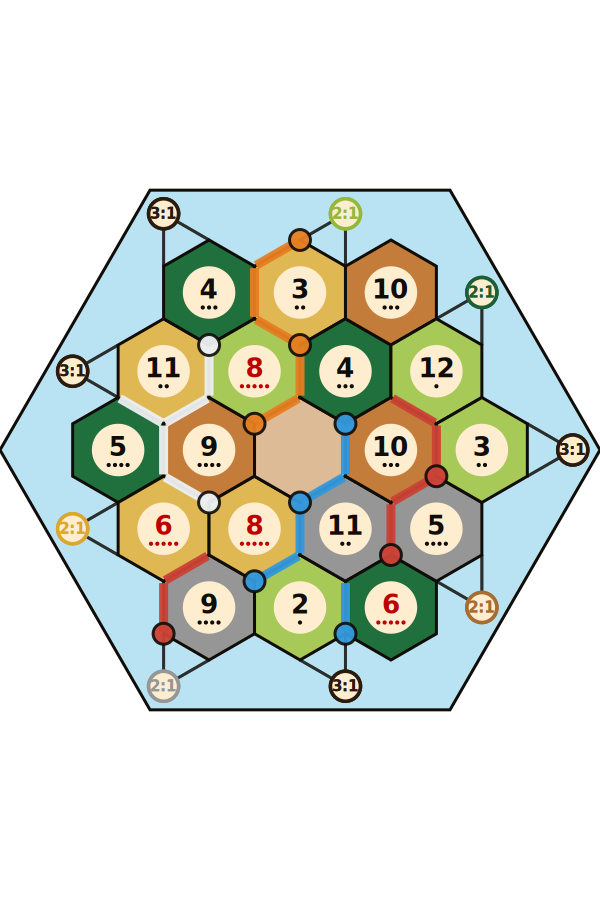

In [8]:
settlements = [
    [Vertex(1,1,1), Vertex(0,2,1), Vertex(-3,3,1)],
    [Vertex(0,0,0), Vertex(1,-1,0), Vertex(-1,1,0), Vertex(-1,3,1)],
    [Vertex(0,-1,0), Vertex(1,-2,0), Vertex(1,-2,1)],
    [Vertex(-1,0,0), Vertex(0,-2,0)]
]

roads = [
    [Edge(Hex(1,0), Hex(2,-1)), Edge(Hex(1,0), Hex(2,0)), Edge(Hex(1,0), Hex(1,1)), Edge(Hex(0,1), Hex(1,1)), Edge(Hex(-3,2), Hex(-2,2)), Edge(Hex(-2,1), Hex(-2,2))],
    [Edge(Hex(-1,2), Hex(0,2)), Edge(Hex(-1,1), Hex(-1,2)), Edge(Hex(-1,1), Hex(0,1)), Edge(Hex(0,0), Hex(0,1)), Edge(Hex(0,0), Hex(1,0))],
    [Edge(Hex(0,-1), Hex(0,0)), Edge(Hex(0,-1), Hex(1,-1)), Edge(Hex(0,-1), Hex(1,-2)), Edge(Hex(1,-2), Hex(0,-2)), Edge(Hex(1,-2), Hex(1,-3))],
    [Edge(Hex(-1,0), Hex(-2,1)), Edge(Hex(-2,0), Hex(-1,0)), Edge(Hex(-1,-1), Hex(-1,0)), Edge(Hex(-1,-1), Hex(0,-1)), Edge(Hex(-1,-1), Hex(-2,0))]
]

hex_grid = create_hexagonal_grid(2)
d = draw_board(layout_grid, board, hex_grid, scale = 1.5)
draw_game(d, layout_grid, settlements, roads, team_colours)
draw_harbours(d, layout_grid, board)
d

In [10]:
d.save_png('../assets/catan_board.png')